In [27]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\junka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Import the file and dropped some less useful columns.

side note: for the dates, I just assumed that 'Stay Date' is more important rather than 'Created Date' or 'Published Date'.

In [28]:
df = pd.read_csv("tripadvisor_20250213222526.csv")
df = df.drop(columns=['Review Id', 'Display Name', 'User Name', 'User Profile',
                      'User Avatar', 'User Is Verified','Additional Ratings', 'Photos',
                       'Location Id', 'URL', 'Created Date', 'Published Date', 'Location'])

In [29]:
print(df.columns)

Index(['User ID', 'User Location', 'Rating', 'Review Title', 'Review Text',
       'Helpful Votes', 'Stay Date', 'Language'],
      dtype='object')


Observed that there are reviews not in english

In [30]:
print(df["Language"].unique())

['en' 'zhCN' 'es' 'ru' 'pl' 'fr' 'sv' 'ja' 'ko' 'da' 'in' 'it' 'nl' 'th'
 'de' 'ar' 'pt' 'el' 'zhTW' 'tr' 'no' 'vi' 'fi' 'iw' 'sk' 'hu' 'sr' 'cs']


After removing non-english reviews, there are 7076 rows left

In [31]:
df = df[df['Language'] == 'en']
#drop Language col after filtering for only english reviews
df = df.drop(columns = ['Language'])


print(df.columns)  #Displayes the columns in the df
print(df.shape[0])  # Displays the number of rows


Index(['User ID', 'User Location', 'Rating', 'Review Title', 'Review Text',
       'Helpful Votes', 'Stay Date'],
      dtype='object')
7076


There are 2 Locations 'Universal Studios Singapore' and 'Universal Studios Singapore Tickets' but after looking at the reviews, 
they seem to be used interchangebly by reviewers.

I.e. There are reviewers who put the location as 'Universal Studios Singapore Tickets' that also talking about the park as a whole as opposed to just talking about the ticketing system or just the queue.

Therefore, will drop 'Location' column as well. (Do it above with the rest to be neater)

In [32]:
''' 

print(df["Location"].unique())
count = df[df['Location'] == 'Universal Studios Singapore Tickets'].shape[0]
print(count)
count2 = df[df['Location'] == 'Universal Studios Singapore'].shape[0]
print(count2)

pd.set_option('display.max_colwidth', None)  # Set to None to show full text without truncation

filtered_reviews = df[df['Location'] == 'Universal Studios Singapore Tickets']['Review Title']
print(filtered_reviews)

'''


' \n\nprint(df["Location"].unique())\ncount = df[df[\'Location\'] == \'Universal Studios Singapore Tickets\'].shape[0]\nprint(count)\ncount2 = df[df[\'Location\'] == \'Universal Studios Singapore\'].shape[0]\nprint(count2)\n\npd.set_option(\'display.max_colwidth\', None)  # Set to None to show full text without truncation\n\nfiltered_reviews = df[df[\'Location\'] == \'Universal Studios Singapore Tickets\'][\'Review Title\']\nprint(filtered_reviews)\n\n'

The column 'User Location' has 1654 missing values, we might want to consider removing these too, especially if we're not doing a demographic by location analysis.

In [33]:
print(df.isnull().sum())  # Check for missing values in each column
# Print the data types of each column


User ID             0
User Location    1654
Rating              0
Review Title        0
Review Text         0
Helpful Votes       0
Stay Date           0
dtype: int64


Converting to the right data types


In [34]:
print(df.dtypes)

#Convert 'Stay Date' to a date type variable
df['Stay Date'] = pd.to_datetime(df['Stay Date'], errors='coerce')



User ID          object
User Location    object
Rating            int64
Review Title     object
Review Text      object
Helpful Votes     int64
Stay Date        object
dtype: object


Text preprocessing:

Remove special characters, numbers, and extra spaces.

Convert text to lowercase.

Tokenization (split text into words).

Remove stop words (common words like "the", "is", "and", etc. that don’t add much meaning).


In [35]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """Lowercase, remove special characters, and extra spaces."""
    text = text.lower().strip()
    text = re.sub(r'[^a-z0-9\s]', '', text) # Keep only alphanumeric characters
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words] # Remove stopwords + Lemmatization
    return ' '.join(words)

df['Clean Review Title'] = df['Review Title'].apply(clean_text)
df['Clean Review Text'] = df['Review Text'].apply(clean_text)

Finally, we can preview the dataset below

In [36]:
print(df.head())

                            User ID  User Location  Rating  \
0  2165A55827C624A5FA8BA42A63DA343C  United States       3   
1  87364D4E6E971222E18CB6C485C9209E            NaN       5   
2  DC02DAA61A0CD9DC77B4C83FC2A79A09      Edinburgh       4   
3  3E7A5D8CEA2FB93CCB415499204B9E77            NaN       1   
4  C9CC6FD8B4C7A6EC72E0088AF811CA82         Sydney       4   

                    Review Title  \
0                      It’s okay   
1  Great Staff, Great Experience   
2    Great day out, pretty small   
3                      Pointless   
4                        Fun day   

                                                                                                                                                                                                                                                                                                                                                                                                                          

C:\Users\junka\AppData\Local\Temp\ipykernel_23612\1184892035.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='viridis')


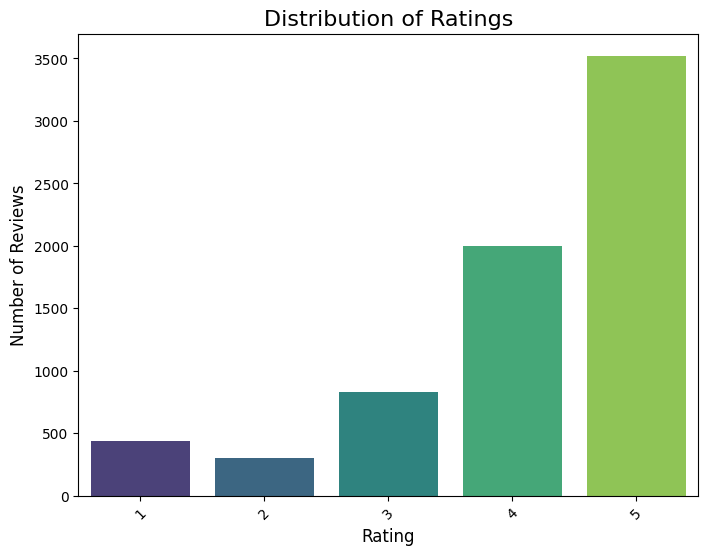

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each rating
rating_counts = df['Rating'].value_counts().sort_index()

# Create the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='viridis')

# Adding labels and title
plt.title('Distribution of Ratings', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(rotation=45)

# Show the plot
plt.show()


We attempt to do sentiment analyis. Sentiment analysis helps in the understanding of emotional tone behind the text data

In [37]:
import nltk
#nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()


def get_sentiment(text):
    sentiment = sid.polarity_scores(text)
    return sentiment['compound']  # The compound score indicates overall sentiment

df['Sentiment'] = df['Clean Review Text'].apply(get_sentiment)
df['Sentiment_Label'] = df['Sentiment'].apply(lambda x: 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral'))
df['Sentiment_Label'].value_counts()



Sentiment_Label
positive    6383
negative     566
neutral      127
Name: count, dtype: int64

C:\Users\junka\AppData\Local\Temp\ipykernel_23612\200535832.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Sentiment_Label', y='Rating', data=df, palette='viridis')


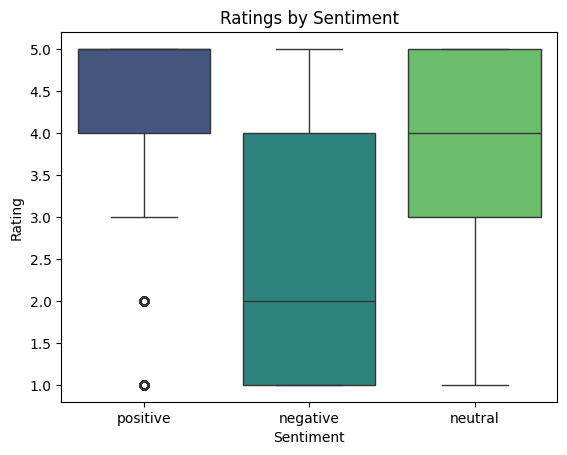

In [48]:
sns.boxplot(x='Sentiment_Label', y='Rating', data=df, palette='viridis')
plt.title('Ratings by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Rating')
plt.show()



C:\Users\junka\AppData\Local\Temp\ipykernel_21272\3616727118.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment_Label', data=df, palette='viridis')


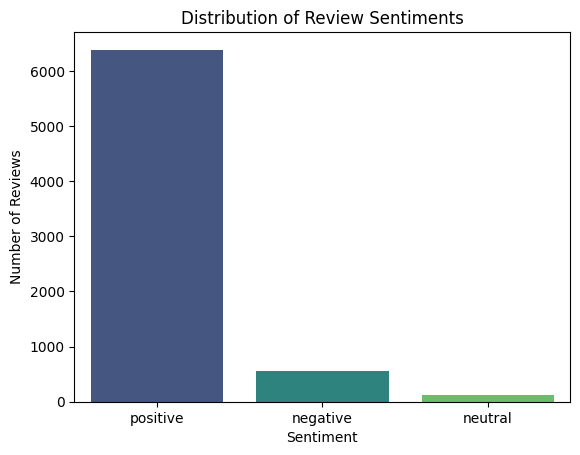

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot sentiment distribution
sns.countplot(x='Sentiment_Label', data=df, palette='viridis')
plt.title('Distribution of Review Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()


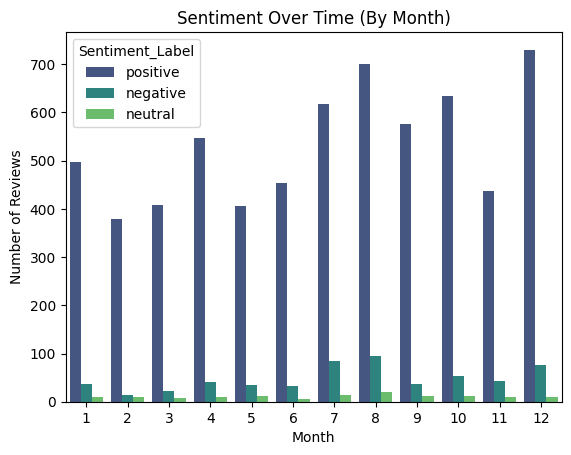

In [ ]:
df['Stay Date'] = pd.to_datetime(df['Stay Date'])
df['Month'] = df['Stay Date'].dt.month

# Plot sentiment by month
sns.countplot(x='Month', hue='Sentiment_Label', data=df, palette='viridis')
plt.title('Sentiment Over Time (By Month)')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.show()


Bigram

positive: Express pass and queue time and rides.

negative: express pass price and qwueu.

In [ ]:

from sklearn.feature_extraction.text import CountVectorizer

# Create bigrams (or trigrams)
vectorizer = CountVectorizer(ngram_range=(2, 2))  # (2, 2) for bigrams, change to (3, 3) for trigrams
positive_reviews = df[df['Sentiment_Label'] == 'positive']['Clean Review Text']
negative_reviews = df[df['Sentiment_Label'] == 'negative']['Clean Review Text']

# Create the term-document matrix for positive and negative reviews
positive_ngrams = vectorizer.fit_transform(positive_reviews)
negative_ngrams = vectorizer.transform(negative_reviews)

# Get the sum of each bigram
positive_ngrams_sum = positive_ngrams.sum(axis=0).A1
negative_ngrams_sum = negative_ngrams.sum(axis=0).A1

# Get the feature names (bigrams)
positive_ngrams_words = vectorizer.get_feature_names_out()
negative_ngrams_words = vectorizer.get_feature_names_out()

# Create DataFrames to view the bigrams and their counts
positive_bigrams = pd.DataFrame(list(zip(positive_ngrams_words, positive_ngrams_sum)), columns=["Bigram", "Count"])
negative_bigrams = pd.DataFrame(list(zip(negative_ngrams_words, negative_ngrams_sum)), columns=["Bigram", "Count"])

# Sort by frequency
positive_bigrams = positive_bigrams.sort_values(by="Count", ascending=False).head(20)
negative_bigrams = negative_bigrams.sort_values(by="Count", ascending=False).head(20)

print("Top 20 Positive Bigrams:")
print(positive_bigrams)

print("\nTop 20 Negative Bigrams:")
print(negative_bigrams)


Top 20 Positive Bigrams:
                      Bigram  Count
142357      universal studio   2244
46735            express pas   1450
113076        roller coaster   1044
133031            theme park    967
139445      transformer ride    745
69054          jurassic park    732
147012          waiting time    611
146635             wait time    491
129246      studio singapore    462
46800         express ticket    429
75824             long queue    423
85540             mummy ride    366
16008   battlestar galactica    358
58885              great day    327
151535             whole day    321
154475              year old    316
48638               fast pas    310
20664            buy express    300
85944             must visit    291
110137         revenge mummy    286

Top 20 Negative Bigrams:
                  Bigram  Count
142357  universal studio    161
46735        express pas    135
147012      waiting time     77
133031        theme park     77
146635         wait time     69
4

we notice that express pass were mentioned in both the positive and negative reviews. Let us furhter understand by gathering the context behind them.

for negative reviwes: express passes were seen as being too expensive. Express passes were also seen to be unworth it, complaints being the exoress queue did not move much faster than the ordinary one. Cost vs benefit

for postive reviews: express passes being time-saving 

In [41]:
# Show first 5 negative reviews mentioning "express pass"
negative_express = df[
    (df['Sentiment_Label'] == 'negative') & 
    (df['Clean Review Text'].str.contains('express pass', case=False, na=False))
]
print(negative_express[['Rating', 'Review Text']].head(5))

# Show first 5 positive reviews mentioning "express pass"
positive_express = df[
    (df['Sentiment_Label'] == 'positive') & 
    (df['Clean Review Text'].str.contains('express pass', case=False, na=False))
]
print(positive_express[['Rating', 'Review Text']].head(5))


     Rating  \
46        1   
355       2   
391       3   
399       2   
508       1   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             